In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define the WNVParameters class
class WNVParameters:
    def __init__(self, temperature=25, precipitation=35):
        self.temperature = temperature
        self.precipitation = precipitation
        self.transovarial_rate = 0.7  # Probability of vertical transmission in mosquitoes
        self.mosquito_life_span = 15  # Average lifespan of mosquitoes in days
        self.bird_life_span = 365  # Average lifespan of birds in days
        self.initial_mosquito_count = 5000
        self.initial_bird_count = 2000
        self.initial_infectious_fraction = 0.2
        self.recovery_rate = 0.05  # Probability of recovery for infected birds
        self.grid_width = 2371
        self.grid_height = 1071
        self.simulation_steps = 30  # Run for one month
        self.mosquito_group_size = 100

    def mosquito_abundance_probability(self, T):
        optimal_temp = 25  # Optimal temperature for Culex mosquitoes
        sigma = 5
        if T >= optimal_temp :
            sigma = 9  # Controls the width of the peak around the optimal temperature
        temp_factor = np.exp(-0.5 * ((T - optimal_temp) / sigma) ** 2)  # Gaussian function for temperature
        temp_factor = np.clip(temp_factor, 0, 1)  # Ensuring values are between 0 and 1
        return temp_factor * (1 - (T - 25) / 26)  # Gradually decrease after 26

    def mosquito_birth_rate(self, T, P):
        optimal_temp = 25  # Optimal temperature for Culex mosquitoes
        optimal_precip = 70  # Optimal precipitation for mosquito breeding
        # Temperature factor remains the same
        temp_factor = np.exp(-0.02 * (T - optimal_temp) ** 2)  # Gaussian function for temperature
        # Ensure P doesn't go below a small positive value to avoid division by zero
        P = np.clip(P, 1e-6, None)  # Clip P to avoid division by zero
        
        # Adjust the precipitation factor with a wider Gaussian curve
        precip_factor = np.where(P < 25,
                                np.exp(-0.0005 * (P - optimal_precip) ** 2) * (P / 25),
                                np.where(P <= 100,
                                        np.exp(-0.0005 * (P - optimal_precip) ** 2),
                                        np.exp(-0.0005 * (P - optimal_precip) ** 2) * (100 / P)))
        
        # Combine factors with baseline birth rate
        return 0.05 + 0.2 * temp_factor * precip_factor


    def egg_to_larvae_rate(self, T, P):
        return 1
        optimal_temp = 25  # Optimal temperature for mosquito eggs
        optimal_precip = 50  # Optimal precipitation for mosquito breeding
        temp_factor = np.exp(-0.02 * (T - optimal_temp) ** 2)  # Wider Gaussian function for temperature
        precip_factor = np.exp(-0.01 * (P - optimal_precip) ** 2)  # Wider Gaussian function for precipitation
        return 0.1 + 0.2 * temp_factor * precip_factor

    def larvae_to_pupae_rate(self, T, P):
        return 1
        optimal_temp = 25  # Optimal temperature for mosquito larvae
        optimal_precip = 50  # Optimal precipitation for mosquito breeding
        temp_factor = np.exp(-0.02 * (T - optimal_temp) ** 2)  # Wider Gaussian function for temperature
        precip_factor = np.exp(-0.01 * (P - optimal_precip) ** 2)  # Wider Gaussian function for precipitation
        return 0.1 + 0.3 * temp_factor * precip_factor

    def pupae_to_adult_rate(self, T, P):
        return 1
        optimal_temp = 25  # Optimal temperature for mosquito pupae
        optimal_precip = 50  # Optimal precipitation for mosquito breeding
        temp_factor = np.exp(-0.02 * (T - optimal_temp) ** 2)  # Wider Gaussian function for temperature
        precip_factor = np.exp(-0.01 * (P - optimal_precip) ** 2)  # Wider Gaussian function for precipitation
        return 0.1 + 0.4 * temp_factor * precip_factor

    def bird_birth_rate(self, T):
        optimal_temp = 20  # Optimal temperature for American crows
        variance = 0.005  # Decrease this value to make the curve wider
        temp_factor = np.exp(-variance * (T - optimal_temp) ** 2)  # Gaussian function for temperature
        return 0.08 * temp_factor * 0.5  # Decrease multiplier to make the peak lower

    def mosquito_death_rate(self, T):
        optimal_temp = 25  # Optimal temperature for Culex mosquitoes
        temp_factor = 0.05 + np.exp(0.01 * (T - optimal_temp) ** 2)  # Inverse Gaussian function for temperature
        return 0.05 * temp_factor

    def bird_death_rate(self, T):
        optimal_temp = 35  # Optimal temperature for American crows
        spread = 15  # Spread factor to control the steepness of the curve
        temp_factor = np.exp(-((T - optimal_temp) ** 2) / (2 * spread ** 2))
        # Adjusted to make the minimum death rate higher
        return 0.04 * (1 - temp_factor)


    def infection_probability(self, T):
        optimal_temp = 25  # Optimal temperature for WNV transmission
        spread = 10  # Spread factor to control the steepness of the curve
        temp_factor = np.exp(-((T - optimal_temp) ** 2) / (2 * spread ** 2))
        return 0.1 * temp_factor

In [3]:
# Instantiate the model
model = WNVParameters()

# Generate data
T_range = np.linspace(0, 50, 100)
P_range = np.linspace(0, 100, 100)
T, P = np.meshgrid(T_range, P_range)



# Plot each function
def plot_surface(Z, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, P, Z, cmap='viridis')
    ax.set_xlabel('Temperature (T)')
    ax.set_ylabel('Precipitation (P)')
    ax.set_zlabel(title)
    plt.title(title)
    plt.show()

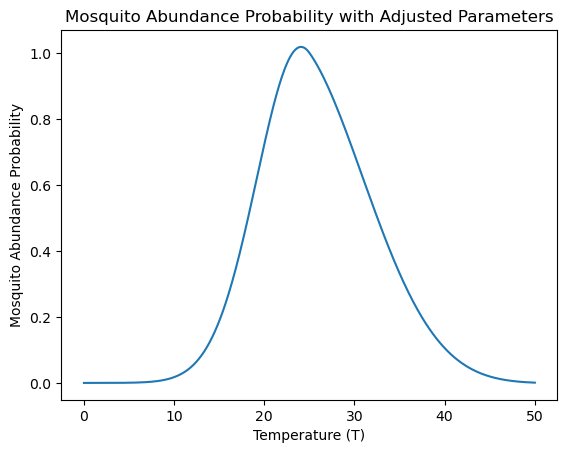

In [5]:
T_values = np.linspace(0, 50, 500)
probabilities = [model.mosquito_abundance_probability(T) for T in T_values]

plt.plot(T_values, probabilities)
plt.xlabel('Temperature (T)')
plt.ylabel('Mosquito Abundance Probability')
plt.title('Mosquito Abundance Probability with Adjusted Parameters')
plt.show()

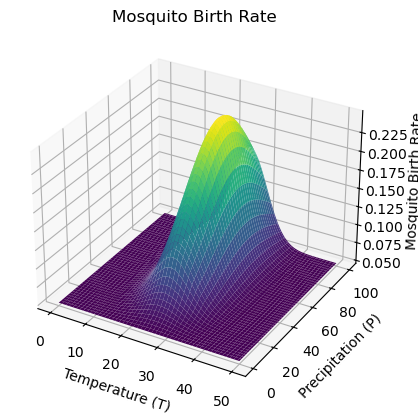

In [7]:
# Plot mosquito birth rate
Z = model.mosquito_birth_rate(T, P)
plot_surface(Z, 'Mosquito Birth Rate')


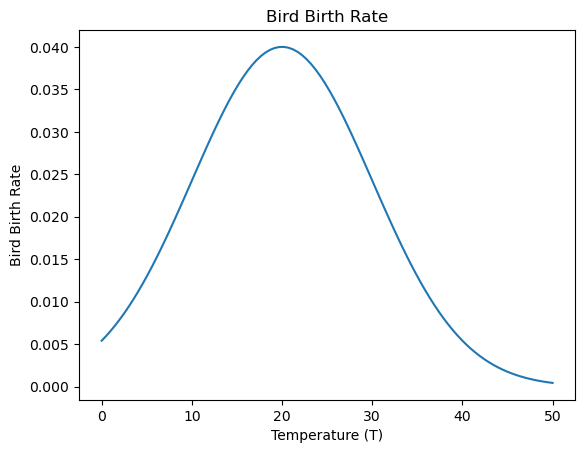

In [8]:

# Plot bird birth rate (only T, so no precipitation)
T_bird = np.linspace(0, 50, 100)
Z_bird = model.bird_birth_rate(T_bird)
plt.figure()
plt.plot(T_bird, Z_bird)
plt.xlabel('Temperature (T)')
plt.ylabel('Bird Birth Rate')
plt.title('Bird Birth Rate')
plt.show()

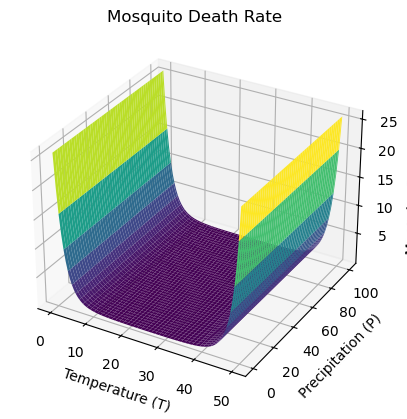

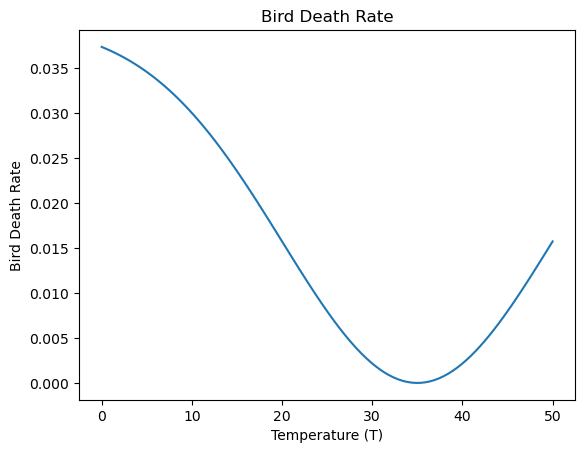

In [9]:
Z = model.mosquito_death_rate(T)
plot_surface(Z, 'Mosquito Death Rate')

# Plot bird death rate (only T, so no precipitation)
Z_bird_death = model.bird_death_rate(T_bird)
plt.figure()
plt.plot(T_bird, Z_bird_death)
plt.xlabel('Temperature (T)')
plt.ylabel('Bird Death Rate')
plt.title('Bird Death Rate')
plt.show()

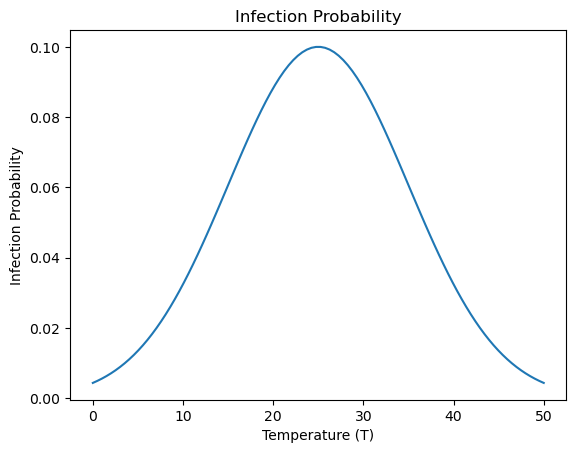

In [10]:
Z_infection = model.infection_probability(T_bird)
plt.figure()
plt.plot(T_bird, Z_infection)
plt.xlabel('Temperature (T)')
plt.ylabel('Infection Probability')
plt.title('Infection Probability')
plt.show()